<a href="https://colab.research.google.com/github/Psyclophe/Data-Scientist/blob/main/Wal_mart_analysis_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Series de tiempo
import scipy.stats as stats
import statistics
from statsmodels.tsa.seasonal import seasonal_decompose # graficas de estacionalidad y tendencia
from statsmodels.tsa.stattools import adfuller # prueba 
from statsmodels.tsa.statespace.sarimax import SARIMAX #SARIMAX

from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler  # Estandarización de los datos
from sklearn.model_selection import cross_val_score

In [2]:
!pip install pmdarima --user

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.9 MB/s eta 0:00:00


In [3]:
import datetime
from pandas.core.indexes.datetimes import date
import pandas as pd
import numpy as np
import scipy as sp
import statsmodels as sm
import sklearn as sl

import pmdarima as pm # autoarima

from pmdarima.arima import auto_arima
from pmdarima.model_selection import train_test_split
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import datetime as dt

import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.stats.multicomp as multi

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.stats.multicomp as mutti

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.compat.scipy import _next_regular

import warnings
warnings.filterwarnings ("ignore")

from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

## sección 1.***Obtención de Datos***
es este apartado se sube la información del dataFrame en github





In [4]:
#se cargan los datos de entrada proporcionado en el proyecto de las tiendas Wal-mart, asimismo se hace la 
#conexión de los datos a Github mostrado en la siguiente ruta
#de la misma forma se indica a Python muestre los primeros "15" registros

url = 'https://raw.githubusercontent.com/Psyclophe/Data-Scientist/main/Walmart_Store_sales.csv'
df = pd.read_csv (url)
print('Shape of data',df.shape)
df.head(15)

Shape of data (6435, 8)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
5,1,12-03-2010,1439541.59,0,57.79,2.667,211.380643,8.106
6,1,19-03-2010,1472515.79,0,54.58,2.720,211.215635,8.106
7,1,26-03-2010,1404429.92,0,51.45,2.732,211.018042,8.106
8,1,02-04-2010,1594968.28,0,62.27,2.719,210.820450,7.808
9,1,09-04-2010,1545418.53,0,65.86,2.770,210.622857,7.808


## sección 2. **Análisis Exploratorio**
en esta sección se procede a realizar el análisis de la información proporcionada con Python

In [5]:
#para identificar el tipo de datos se pide a Python que nos muestre los diferentes tipos datos y, poder detectar la cantidad de datos nulos
df.isnull().sum(axis=0)

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [6]:
#con la carga de informacion y con esta funcion se pide a Python indicar el tipo de dato de cada columna, para analizar si es necesario hacer cambios en el tipo de 
#dato en el dataframe y poder tener datos homogeneos se identifico que "Date" es un dato que es objeto y se debe convertir a dato fecha
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [7]:
df.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

In [8]:
#en esta funcion se pide a Python convertir los datos objeto a string aquí podemos visualizar que el dato que era un objeto "Date" se conviritio al formato fecha 
#en donde se visualiza "datetime64[ns]"
df["Date"]=pd.to_datetime(df["Date"],dayfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


In [9]:
#con este script se pide a Pyhon poner en formato a las cifras de la informacion de dataset
pd.options.display.float_format='{:,.2f}'.format

In [10]:
#con esta funcion se da la instrucción a Python para ver las medidas de tendencia central de las 8 columnas
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,"6,435.00","6,435.00","6,435.00","6,435.00","6,435.00","6,435.00","6,435.00"
mean,23.00,"1,046,964.88",0.07,60.66,3.36,171.58,8.00
std,12.99,"564,366.62",0.26,18.44,0.46,39.36,1.88
min,1.00,"209,986.25",0.00,-2.06,2.47,126.06,3.88
25%,12.00,"553,350.10",0.00,47.46,2.93,131.74,6.89
50%,23.00,"960,746.04",0.00,62.67,3.44,182.62,7.87
75%,34.00,"1,420,158.66",0.00,74.94,3.73,212.74,8.62
max,45.00,"3,818,686.45",1.00,100.14,4.47,227.23,14.31


In [11]:
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,"1,643,690.90",0,42.31,2.57,211.10,8.11
1,1,2010-02-12,"1,641,957.44",1,38.51,2.55,211.24,8.11
2,1,2010-02-19,"1,611,968.17",0,39.93,2.51,211.29,8.11
3,1,2010-02-26,"1,409,727.59",0,46.63,2.56,211.32,8.11
4,1,2010-03-05,"1,554,806.68",0,46.50,2.62,211.35,8.11
...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,"713,173.95",0,64.88,4.00,192.01,8.68
6431,45,2012-10-05,"733,455.07",0,64.89,3.98,192.17,8.67
6432,45,2012-10-12,"734,464.36",0,54.47,4.00,192.33,8.67
6433,45,2012-10-19,"718,125.53",0,56.47,3.97,192.33,8.67


In [12]:
#se da la instruccion a Python que se ordene las fechas de menor a mayor en el archivo que se va a analizar asimismo se indica al programa que ordene por fechas, 
#de la mas antigua hasta la mas reciente
data_sort=df.sort_values("Date")
data_sort

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,"1,643,690.90",0,42.31,2.57,211.10,8.11
1287,10,2010-02-05,"2,193,048.75",0,54.34,2.96,126.44,9.77
5148,37,2010-02-05,"536,006.73",0,45.97,2.57,209.85,8.55
2288,17,2010-02-05,"789,036.02",0,23.11,2.67,126.44,6.55
4147,30,2010-02-05,"465,108.52",0,39.05,2.57,210.75,8.32
...,...,...,...,...,...,...,...,...
3574,25,2012-10-26,"688,940.94",0,56.69,3.88,216.15,7.29
714,5,2012-10-26,"319,550.77",0,71.70,3.51,224.04,5.42
5719,40,2012-10-26,"921,264.52",0,49.65,3.92,138.73,4.14
2573,18,2012-10-26,"1,127,516.25",0,56.09,3.92,138.73,8.24


In [13]:
#con este script se pide a Python separar el dato "Date" en year, quarter, month, week & day,
df["Year"]= df['Date'].dt.year
df["Quarter"]= df['Date'].dt.quarter
df["Month"]= df['Date'].dt.month
df["Week"]= df['Date'].dt.week
df["Day"]= df['Date'].dt.day
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day
0,1,2010-02-05,"1,643,690.90",0,42.31,2.57,211.10,8.11,2010,1,2,5,5
1,1,2010-02-12,"1,641,957.44",1,38.51,2.55,211.24,8.11,2010,1,2,6,12
2,1,2010-02-19,"1,611,968.17",0,39.93,2.51,211.29,8.11,2010,1,2,7,19
3,1,2010-02-26,"1,409,727.59",0,46.63,2.56,211.32,8.11,2010,1,2,8,26
4,1,2010-03-05,"1,554,806.68",0,46.50,2.62,211.35,8.11,2010,1,3,9,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,"713,173.95",0,64.88,4.00,192.01,8.68,2012,3,9,39,28
6431,45,2012-10-05,"733,455.07",0,64.89,3.98,192.17,8.67,2012,4,10,40,5
6432,45,2012-10-12,"734,464.36",0,54.47,4.00,192.33,8.67,2012,4,10,41,12
6433,45,2012-10-19,"718,125.53",0,56.47,3.97,192.33,8.67,2012,4,10,42,19


In [14]:
#con la funcion "groupby" se indica a Python agrupar y sumar, por tienda y por semana, al ejecutar el script Python agrega e indexa la columna "0" a la columna "1" 
#como identificador
group=df.groupby("Store").sum("Weekly_Sales")
group.reset_index(level=0, inplace=True)
group["Weekly_Sales"]=(group["Weekly_Sales"])
group

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day
0,1,"222,402,808.85",10,"9,767.87",460.42,"30,887.56","1,088.29",287568,355,922,3692,2242
1,2,"275,382,440.98",10,"9,754.94",460.42,"30,837.42","1,090.21",287568,355,922,3692,2242
2,3,"57,586,735.07",10,"10,215.09",460.42,"31,372.99","1,026.31",287568,355,922,3692,2242
3,4,"299,543,953.38",10,"8,902.23",460.03,"18,401.19",852.95,287568,355,922,3692,2242
4,5,"45,475,688.90",10,"9,925.65",460.42,"30,968.88",900.24,287568,355,922,3692,2242
5,6,"223,756,130.64",10,"9,967.10",460.42,"31,110.11",944.79,287568,355,922,3692,2242
6,7,"81,598,275.14",10,"5,680.00",463.54,"27,693.99","1,227.76",287568,355,922,3692,2242
7,8,"129,951,181.13",10,"8,939.50",460.42,"31,379.78",871.13,287568,355,922,3692,2242
8,9,"77,789,218.99",10,"9,691.85",460.42,"31,406.62",872.28,287568,355,922,3692,2242
9,10,"271,617,713.89",10,"10,330.49",511.36,"18,401.19","1,195.90",287568,355,922,3692,2242


In [15]:
#se solicita a Python ordenar por tienda y por volumen de ventas, del valor mayor al menor
sort_WeeklySales=group.sort_values('Weekly_Sales', ascending=False)
sort_WeeklySales

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day
19,20,"301,397,792.46",10,"7,929.55",488.72,"29,892.45","1,054.11",287568,355,922,3692,2242
3,4,"299,543,953.38",10,"8,902.23",460.03,"18,401.19",852.95,287568,355,922,3692,2242
13,14,"288,999,911.34",10,"8,264.11",488.72,"26,638.85","1,236.77",287568,355,922,3692,2242
12,13,"286,517,703.80",10,"7,678.69",469.92,"18,401.19","1,001.26",287568,355,922,3692,2242
1,2,"275,382,440.98",10,"9,754.94",460.42,"30,837.42","1,090.21",287568,355,922,3692,2242
9,10,"271,617,713.89",10,"10,330.49",511.36,"18,401.19","1,195.90",287568,355,922,3692,2242
26,27,"253,855,916.88",10,"8,195.49",511.70,"19,878.61","1,144.25",287568,355,922,3692,2242
5,6,"223,756,130.64",10,"9,967.10",460.42,"31,110.11",944.79,287568,355,922,3692,2242
0,1,"222,402,808.85",10,"9,767.87",460.42,"30,887.56","1,088.29",287568,355,922,3692,2242
38,39,"207,445,542.47",10,"10,095.42",460.42,"30,706.26","1,125.27",287568,355,922,3692,2242


In [16]:
Top_five=sort_WeeklySales[['Weekly_Sales', 'Store']][0:5:].reset_index(drop=True)
Top_five

,Weekly_Sales,Store
0,"301,397,792.46",20
1,"299,543,953.38",4
2,"288,999,911.34",14
3,"286,517,703.80",13
4,"275,382,440.98",2


In [17]:
#con este script se pide a Python agrupar por Year
group=df.groupby("Year").sum("Weekly_Sales")
group.reset_index(level=0, inplace=True)
group["Weekly_Sales"]=(group["Weekly_Sales"])
group

,Year,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Quarter,Month,Week,Day
0,2010,49680,"2,288,886,120.41",180,"130,176.63","6,099.34","363,099.85","18,344.26",5805,15345,61560,33930
1,2011,53820,"2,448,200,007.35",180,"137,588.56","8,334.88","401,416.98","18,911.96",5940,15480,62010,36270
2,2012,44505,"2,000,132,859.35",90,"122,606.25","7,178.42","339,590.14","14,218.31",4230,10665,42570,30690


In [18]:
#con este script se pide a Python sumar el total de ventas por Year
Sales_Year=df.groupby('Year')['Weekly_Sales'].sum()
Sales_Year

Year
2010   2,288,886,120.41
2011   2,448,200,007.35
2012   2,000,132,859.35
Name: Weekly_Sales, dtype: float64

<Figure size 1440x576 with 0 Axes>

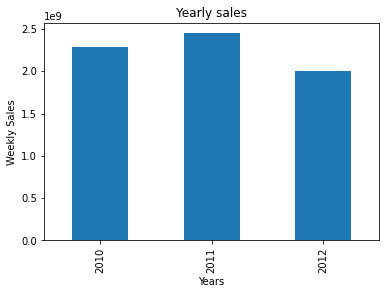

In [19]:
#con este script se pide a python graficar las Ventas Anuales
plt.figure(figsize=(20,8))
df.groupby("Year")[["Weekly_Sales"]].sum().plot(kind='bar',legend=False)
plt.xlabel("Years")
plt.ylabel("Weekly Sales")
plt.title("Yearly sales")
plt.show()

In [20]:
#con este script se pide a Python agrupar por Quarter
group=df.groupby("Quarter").sum("Weekly_Sales")
group.reset_index(level=0, inplace=True)
group["Weekly_Sales"]=(group["Weekly_Sales"])
group

,Quarter,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,Day
0,1,34155,"1,494,112,230.22",135,"63,690.16","4,852.66","254,211.12","11,972.58",2986560,3195,10665,22950
1,2,40365,"1,826,615,243.76",0,"115,643.16","6,142.66","300,998.89","14,079.42",3529305,8730,33930,27090
2,3,41400,"1,841,852,365.33",135,"138,977.33","6,089.62","309,549.33","14,265.98",3619800,14355,58500,28710
3,4,32085,"1,574,639,147.80",180,"72,060.79","4,527.69","239,347.62","11,156.57",2804895,15210,63045,22140


<Figure size 1440x576 with 0 Axes>

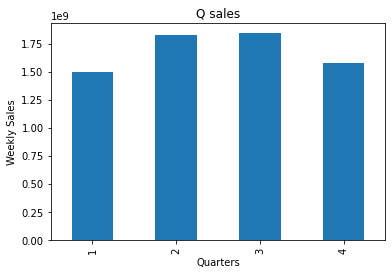

In [21]:
#con este script se pide a python graficar las Ventas by Quarter
plt.figure(figsize=(20,8))
df.groupby("Quarter")[["Weekly_Sales"]].sum().plot(kind='bar',legend=False)
plt.xlabel("Quarters")
plt.ylabel("Weekly Sales")
plt.title("Q sales")
plt.show()

In [22]:
#from pandas.core.groupby.groupby import DataFrame

#con este script se pide a Python realizar la suma y acumulacion por Quarter
#df=DataFrame({'Year', 'Quarter'})
#print(df.groupby(['Year', 'Quarter']).sum().groupby(level=[0]).cumsum())

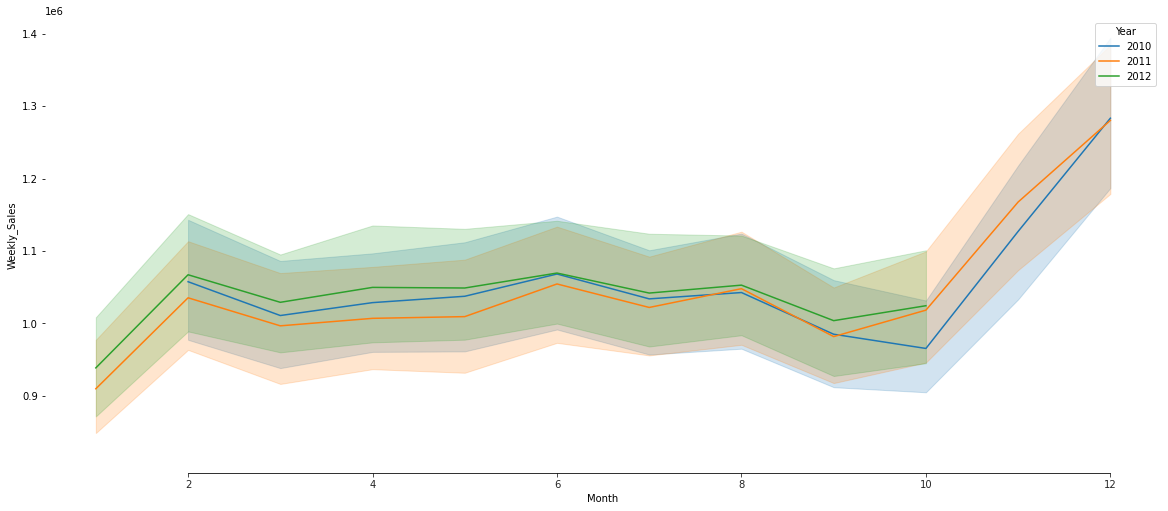

In [23]:
#con este script se pide a Python graficar las ventas por año y por mes
plt.figure(figsize=(20,8))
sns.lineplot(data=df, x='Month', y='Weekly_Sales', hue='Year', palette='tab10')
sns.set_style('whitegrid')
sns.despine(left=True, offset=20, trim=True)
plt.show()

In [24]:
#con este script se pide a Python ordenar por Store 
df.set_index('Store')

,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day
Store,,,,,,,,,,,,
1,2010-02-05,"1,643,690.90",0,42.31,2.57,211.10,8.11,2010,1,2,5,5
1,2010-02-12,"1,641,957.44",1,38.51,2.55,211.24,8.11,2010,1,2,6,12
1,2010-02-19,"1,611,968.17",0,39.93,2.51,211.29,8.11,2010,1,2,7,19
1,2010-02-26,"1,409,727.59",0,46.63,2.56,211.32,8.11,2010,1,2,8,26
1,2010-03-05,"1,554,806.68",0,46.50,2.62,211.35,8.11,2010,1,3,9,5
...,...,...,...,...,...,...,...,...,...,...,...,...
45,2012-09-28,"713,173.95",0,64.88,4.00,192.01,8.68,2012,3,9,39,28
45,2012-10-05,"733,455.07",0,64.89,3.98,192.17,8.67,2012,4,10,40,5
45,2012-10-12,"734,464.36",0,54.47,4.00,192.33,8.67,2012,4,10,41,12


<AxesSubplot:title={'center':'Sales by store'}, xlabel='Store', ylabel='Volume Total Sales'>

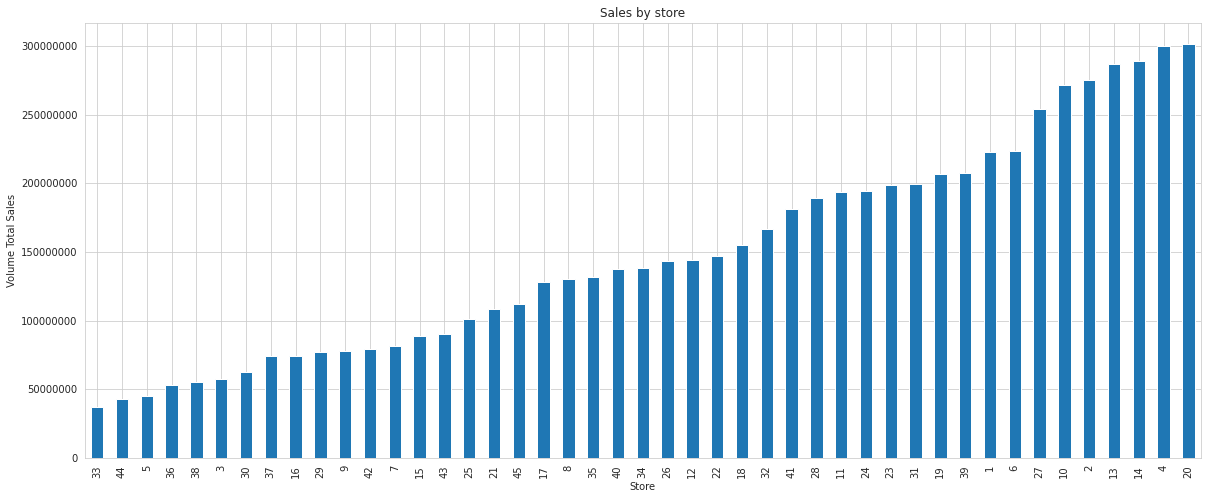

In [25]:
#con este script se pide a Python graficar las ventas por Store
Total_sales= df.groupby('Store')['Weekly_Sales'].sum().sort_values()
Total_sales_array = np.array(Total_sales)
plt.figure(figsize=(20,8))
plt.xticks(rotation=0)
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.title('Sales by store')
plt.xlabel('Store')
plt.ylabel('Volume Total Sales')
Total_sales.plot(kind='bar')

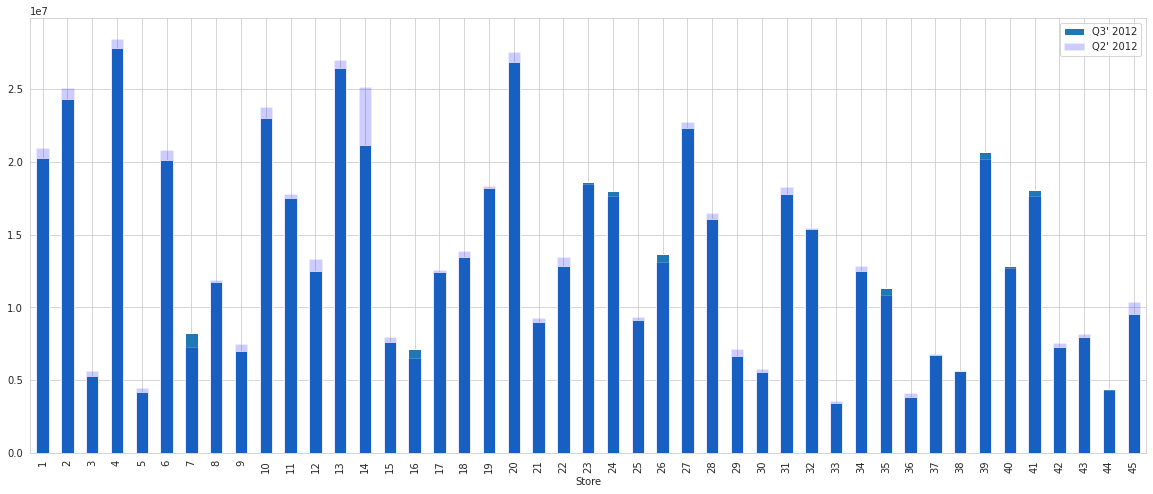

In [26]:
#con este script se agrupan las ventas por el segundo y tercer Q de 2012
Q2_sales = df[(df['Date'] >= '2012-04-01') & (df['Date'] <= '2012-06-30')].groupby('Store')['Weekly_Sales'].sum()
Q3_sales = df[(df['Date'] >= '2012-07-01') & (df['Date'] <= '2012-09-30')].groupby('Store')['Weekly_Sales'].sum()

#con este script se grafica la diferencia en ventas por el segundo y tercer Q
plt.figure(figsize=(20,8))
Q2_sales.plot(ax=Q3_sales.plot(kind ='bar'),kind='bar',color='b',alpha=0.2,legend=True)
plt.legend(["Q3' 2012", "Q2' 2012"])

In [27]:
#en este script se determina el crecimiento entre los Q2 y Q3
Q2_sales= df[(df['Date'] >= '2012-04-01') & (df['Date'] <= '2012-06-30')].groupby('Store')['Weekly_Sales'].sum()
Q3_sales= df[(df['Date'] >= '2012-07-01') & (df['Date'] <= '2012-09-30')].groupby('Store')['Weekly_Sales'].sum()
quarterly_growth_rate = ((Q3_sales - Q2_sales )/Q2_sales)*100
quarterly_growth_rate.sort_values(ascending=False).head()

Store
7    13.33
16    8.49
35    4.47
26    3.96
39    2.48
Name: Weekly_Sales, dtype: float64

<AxesSubplot:xlabel='Store'>

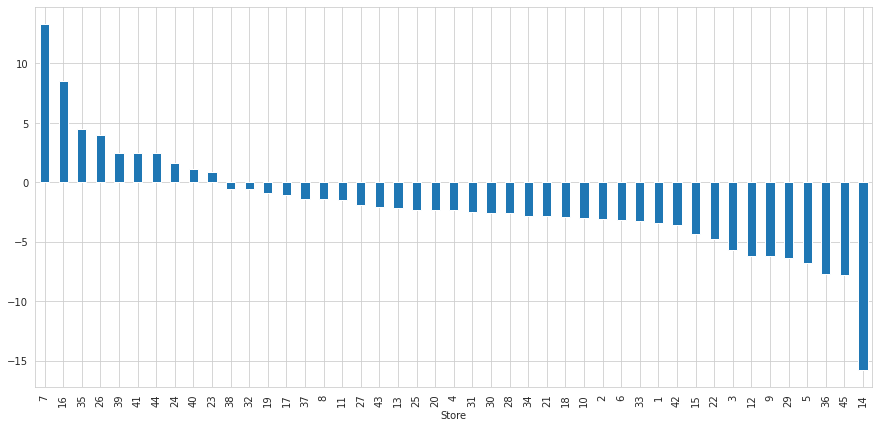

In [28]:
plt.figure(figsize=(15,7))
quarterly_growth_rate.sort_values(ascending=False).plot(kind='bar')

In [29]:
#es este script se solicita a Python calcular la Desviacion Estandar por tienda,
#ordenanda de mayor a menor
Store_devstd = df.groupby('Store')['Weekly_Sales'].std()
Store_devstd = pd.DataFrame(Store_devstd)
Store_devstd=Store_devstd.sort_values('Weekly_Sales', ascending=False)
Store_devstd

,Weekly_Sales
Store,
14,"317,569.95"
10,"302,262.06"
20,"275,900.56"
4,"266,201.44"
13,"265,507.00"
23,"249,788.04"
27,"239,930.14"
2,"237,683.69"
39,"217,466.45"


In [30]:
#con este script Python hace el calculo de la tienda con más desviacion estandar
top_std = pd.DataFrame(df.groupby('Store')['Weekly_Sales'].std().sort_values(ascending=False))
top_std.head(1).index[0] , top_std.head(1).Weekly_Sales[top_std.head(1).index[0]] 

(14, 317569.9494755081)

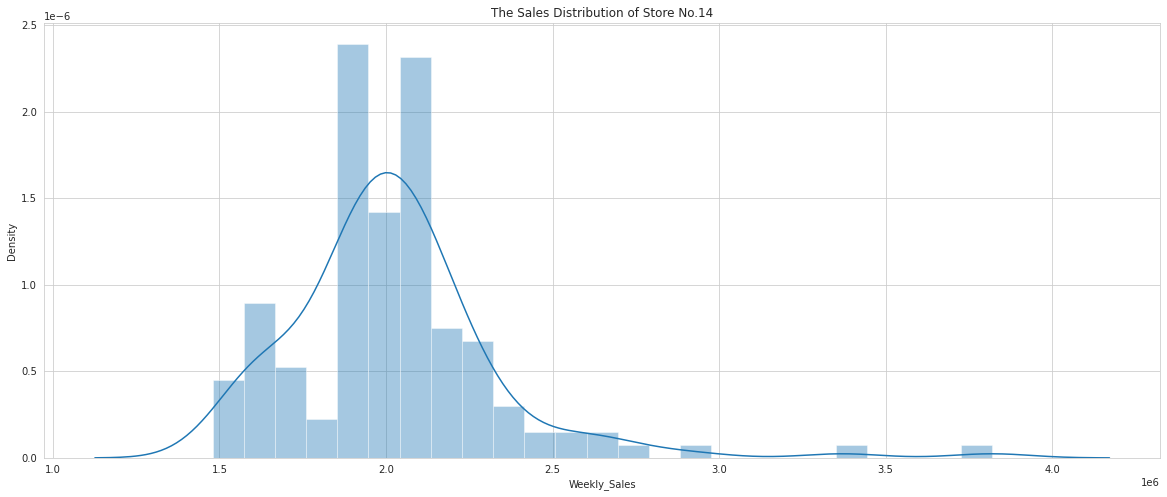

In [31]:
#con este script se pide a Python graficar la DesvStd por tienda
plt.figure(figsize=(20,8))
sns.distplot(df[df['Store'] == top_std.head(1).index[0]]['Weekly_Sales'])
plt.title('The Sales Distribution of Store No.'+ str(top_std.head(1).index[0]))

import warnings
warnings.filterwarnings('ignore')

In [32]:
# con este script se determina el -Coeficiente de Desviación Medio- por tienda el
#se determino dividiendo la DesvStd por tienda entre la media de las tiendas, como sigue coeficiente_DM = Desviación Estandar / media aritmetica * 100
coeficiente_DM = pd.DataFrame(df.groupby('Store')['Weekly_Sales'].std() / df.groupby('Store')['Weekly_Sales'].mean()*100)
coeficiente_DM

,Weekly_Sales
Store,
1,10.03
2,12.34
3,11.50
4,12.71
5,11.87
6,13.58
7,19.73
8,11.70
9,12.69


In [33]:
#se pide a Python filtrar los primeros 7 datos 
coef = pd.DataFrame(df.groupby('Store')['Weekly_Sales'].std() / df.groupby('Store')['Weekly_Sales'].mean()*100)
coef = coef.rename(columns={'Weekly_Sales':'Coefficient of standard deviation'})
coef_max = coef.sort_values(by='Coefficient of standard deviation', ascending=False)
coef_max.head(7)

,Coefficient of standard deviation
Store,
35,22.97
7,19.73
15,19.34
29,18.37
23,17.97
21,17.03
45,16.56


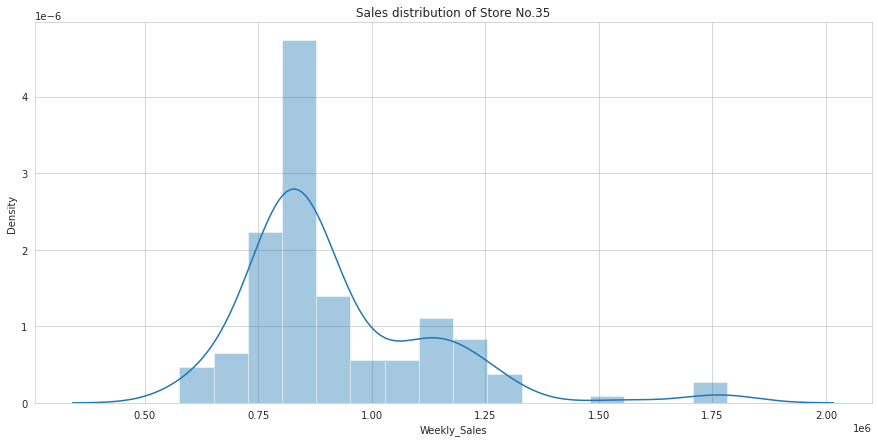

In [34]:
#con este script se pide a Python graficar la distribucion de las Ventas de acuerdo al coeficiente de desviacion standar
plt.figure(figsize=(15,7))
sns.distplot(df[df['Store'] == coef_max.head(1).index[0]]['Weekly_Sales'])
plt.title('Sales distribution of Store No.'+str(coef_max.head(1).index[0]))
import warnings
warnings.filterwarnings('ignore')

In [35]:
#con este script se pide a Python identificar los días festivos
df_Holiday=df[df["Holiday_Flag"]==1]
df_Holiday

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day
1,1,2010-02-12,"1,641,957.44",1,38.51,2.55,211.24,8.11,2010,1,2,6,12
31,1,2010-09-10,"1,507,460.69",1,78.69,2.56,211.50,7.79,2010,3,9,36,10
42,1,2010-11-26,"1,955,624.11",1,64.52,2.73,211.75,7.84,2010,4,11,47,26
47,1,2010-12-31,"1,367,320.01",1,48.43,2.94,211.40,7.84,2010,4,12,52,31
53,1,2011-02-11,"1,649,614.93",1,36.39,3.02,212.94,7.74,2011,1,2,6,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6375,45,2011-09-09,"746,129.56",1,71.48,3.74,186.67,8.62,2011,3,9,36,9
6386,45,2011-11-25,"1,170,672.94",1,48.71,3.49,188.35,8.52,2011,4,11,47,25
6391,45,2011-12-30,"869,403.63",1,37.79,3.39,189.06,8.52,2011,4,12,52,30
6397,45,2012-02-10,"803,657.12",1,37.00,3.64,189.71,8.42,2012,1,2,6,10


In [36]:
#con esta instruccion se definen los Días festivos que encontro Pyton en el dataframe
Super_Bowl =['2010-12-02', '2011-11-02', '2012-10-02']
Labor_Day =  ['2010-10-09', '2011-09-09', '2012-07-09']
Thanksgivig_Day =  ['2010-11-26', '2011-11-25', '2012-11-23']
Xmas = ['2010-12-31', '2011-12-30', '2012-12-28']

In [37]:
#con este script se pide a Python sumar los dias festivos y no festivos
add_days = Super_Bowl + Labor_Day + Thanksgivig_Day + Xmas
add_days
df["Holiday_Flag"] = np.where(df["Holiday_Flag"] == 1, df["Holiday_Flag"], df["Holiday_Flag"].isin(add_days))
df['Holiday_Flag'].value_counts()

0    5985
1     450
Name: Holiday_Flag, dtype: int64

In [38]:
#con esta instruccion se pide a Python determinar la media de ventas de los Dias_Festivos
Sales_Super_Bowl= (pd.DataFrame(df.loc[df.Date.isin(Super_Bowl)]))['Weekly_Sales'].mean()
Sales_Labor_Day = (pd.DataFrame(df.loc[df.Date.isin(Labor_Day)]))['Weekly_Sales'].mean()
Sales_Thanksgivig_Day = (pd.DataFrame(df.loc[df.Date.isin(Thanksgivig_Day)]))['Weekly_Sales'].mean()
Sales_Xmas = (pd.DataFrame(df.loc[df.Date.isin(Xmas)]))['Weekly_Sales'].mean()
{Sales_Super_Bowl, Sales_Labor_Day, Sales_Thanksgivig_Day, Sales_Xmas}

{nan, 960833.1115555555, 1039182.8339999999, 1471273.427777778}

In [39]:
#con esta instruccion se pide a Python determinar la media de ventas de los Dias_No_Festivos
Sales_not_Holiday = df[df['Holiday_Flag'] == 0 ]['Weekly_Sales'].mean()
{Sales_not_Holiday}

{1041256.3802088555}

In [40]:
#con esta instruccion se pide a Python determinar el promedio de ventas 
Average_sales = {'Sales_Super_Bowl' : Sales_Super_Bowl,
                 'Sales_Labor_Day': Sales_Labor_Day,
                 'Sales_Thanksgiving_Day':Sales_Thanksgivig_Day,
                 'Sales_Xmas': Sales_Xmas,
                 'Sales_not_Holiday': Sales_not_Holiday}
Average_sales 

{'Sales_Super_Bowl': nan,
 'Sales_Labor_Day': 1039182.8339999999,
 'Sales_Thanksgiving_Day': 1471273.427777778,
 'Sales_Xmas': 960833.1115555555,
 'Sales_not_Holiday': 1041256.3802088555}

In [41]:
df.groupby('Quarter').sum()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,Day
Quarter,,,,,,,,,,,
1,34155,"1,494,112,230.22",135,"63,690.16","4,852.66","254,211.12","11,972.58",2986560,3195,10665,22950
2,40365,"1,826,615,243.76",0,"115,643.16","6,142.66","300,998.89","14,079.42",3529305,8730,33930,27090
3,41400,"1,841,852,365.33",135,"138,977.33","6,089.62","309,549.33","14,265.98",3619800,14355,58500,28710
4,32085,"1,574,639,147.80",180,"72,060.79","4,527.69","239,347.62","11,156.57",2804895,15210,63045,22140


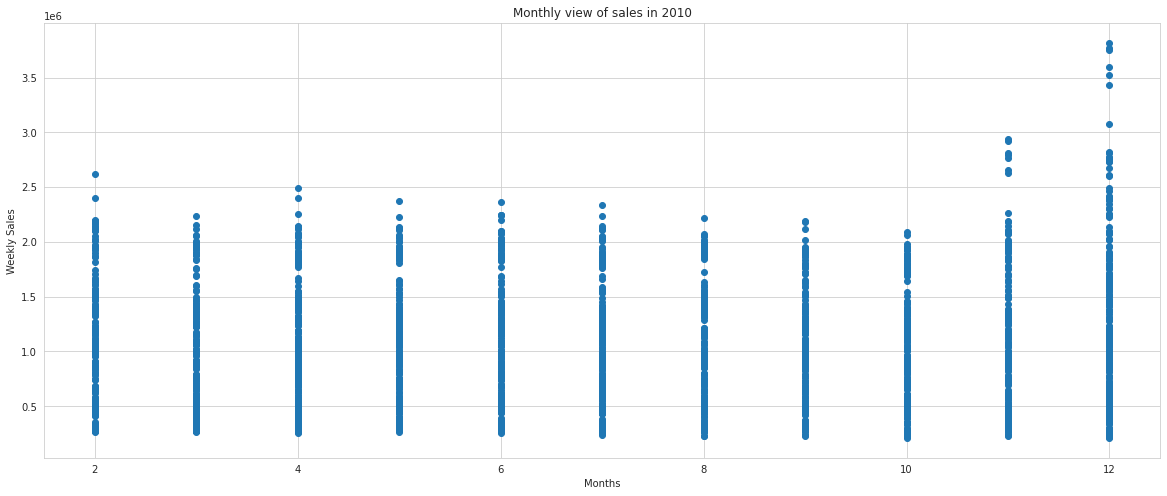

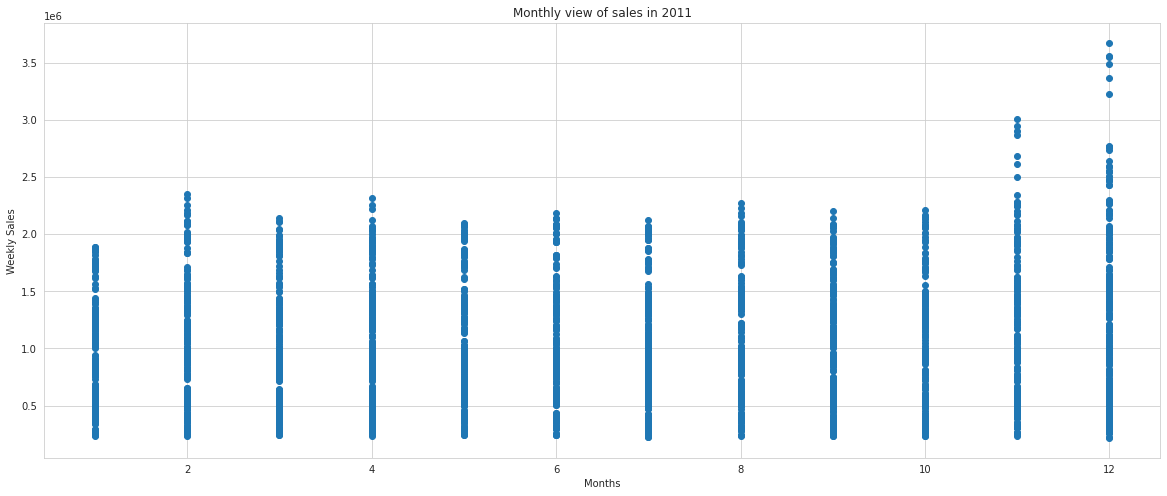

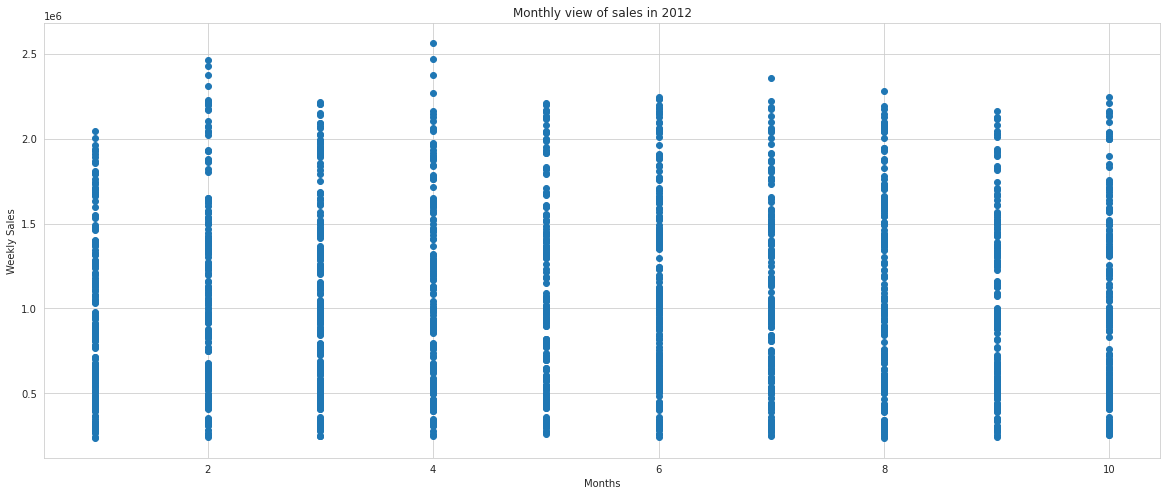

In [42]:
#con este script se pide a Python graficar las Ventas mensuales por cada año 
plt.figure(figsize=(20,8))
plt.scatter(df[df.Year==2010]["Month"],df[df.Year==2010]["Weekly_Sales"])
plt.xlabel("Months")
plt.ylabel("Weekly Sales")
plt.title("Monthly view of sales in 2010")
plt.show()

plt.figure(figsize=(20,8))
plt.scatter(df[df.Year==2011]["Month"],df[df.Year==2011]["Weekly_Sales"])
plt.xlabel("Months")
plt.ylabel("Weekly Sales")
plt.title("Monthly view of sales in 2011")
plt.show()

plt.figure(figsize=(20,8))
plt.scatter(df[df.Year==2012]["Month"],df[df.Year==2012]["Weekly_Sales"])
plt.xlabel("Months")
plt.ylabel("Weekly Sales")
plt.title("Monthly view of sales in 2012")
plt.show()

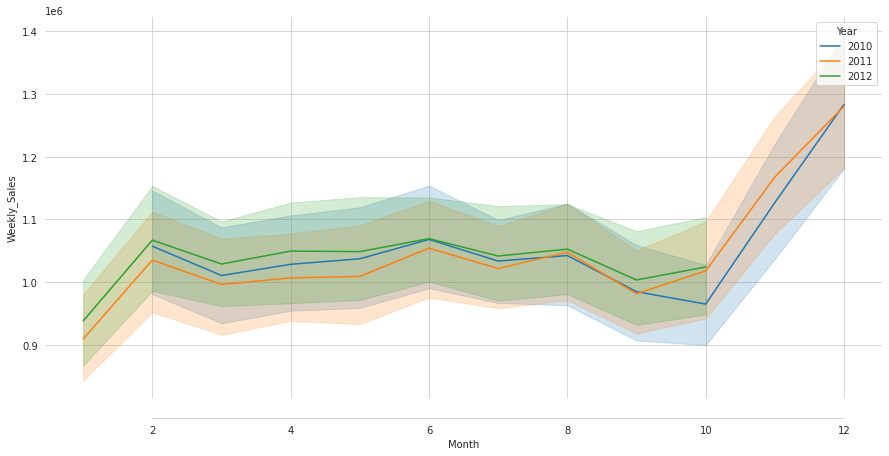

In [43]:
#con esta instrucción se pide a Python graficar las ventas de los tres años de manera mensual
plt.figure(figsize=(15,7))
sns.lineplot(data=df, x='Month', y='Weekly_Sales', hue='Year', palette='tab10')
sns.set_style('whitegrid')
sns.despine(left=True, offset=20, trim=True)
plt.show()

# sección 3. **Quitar Valores de Rango**
en esta sección del codigo se analiza la información para quitar los valores fuera de rango


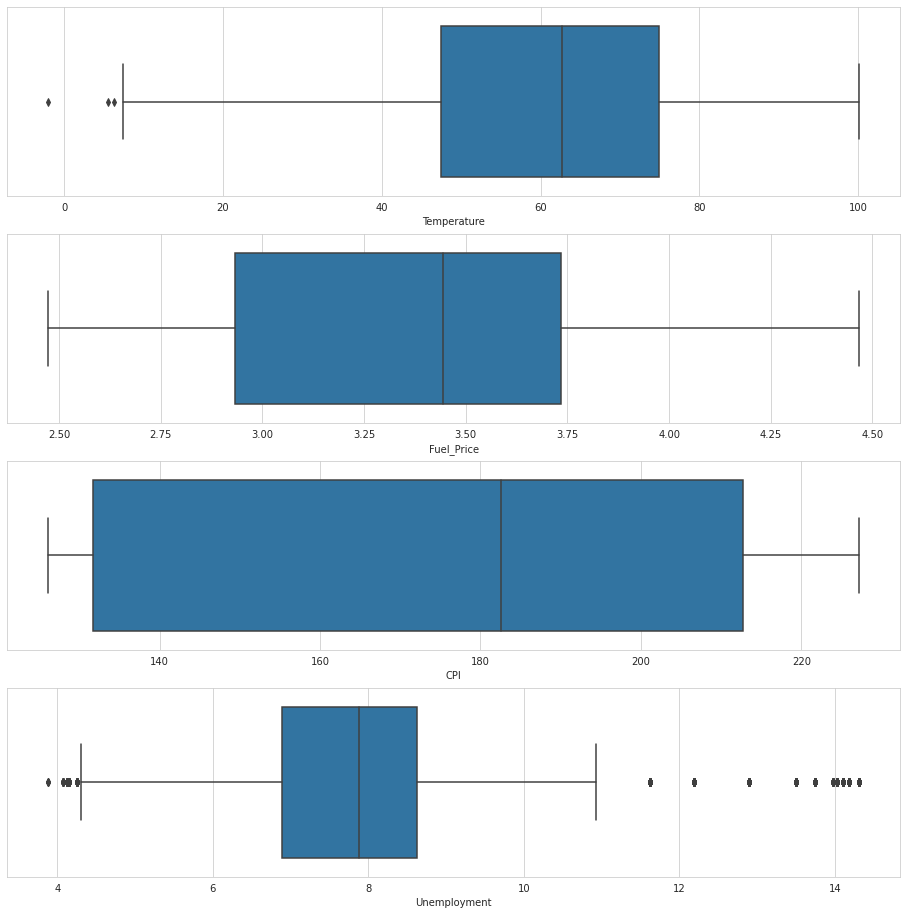

In [44]:
#con este script se grafican y validan los valores atipicos
fig, axis = plt.subplots(4,figsize=(16,16))
X = df[['Temperature','Fuel_Price','CPI','Unemployment']]
for i,column in enumerate(X):
    sns.boxplot(df[column],ax=axis[i])

import warnings
warnings.filterwarnings('ignore')

In [45]:
df_clean = df[(df['Unemployment']<10) & (df['Unemployment']>4.5) & (df['Temperature']>10)]
df_clean

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day
0,1,2010-02-05,"1,643,690.90",0,42.31,2.57,211.10,8.11,2010,1,2,5,5
1,1,2010-02-12,"1,641,957.44",1,38.51,2.55,211.24,8.11,2010,1,2,6,12
2,1,2010-02-19,"1,611,968.17",0,39.93,2.51,211.29,8.11,2010,1,2,7,19
3,1,2010-02-26,"1,409,727.59",0,46.63,2.56,211.32,8.11,2010,1,2,8,26
4,1,2010-03-05,"1,554,806.68",0,46.50,2.62,211.35,8.11,2010,1,3,9,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,"713,173.95",0,64.88,4.00,192.01,8.68,2012,3,9,39,28
6431,45,2012-10-05,"733,455.07",0,64.89,3.98,192.17,8.67,2012,4,10,40,5
6432,45,2012-10-12,"734,464.36",0,54.47,4.00,192.33,8.67,2012,4,10,41,12
6433,45,2012-10-19,"718,125.53",0,56.47,3.97,192.33,8.67,2012,4,10,42,19


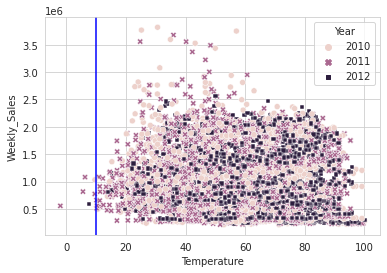

In [46]:
sns.scatterplot(data=df,x='Temperature', y='Weekly_Sales', hue='Year', style='Year')
plt.axvline(x=10,color='b')

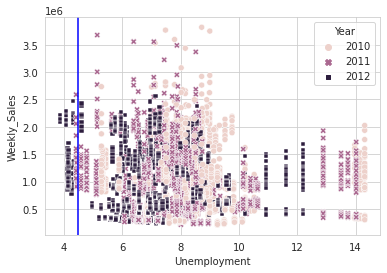

In [47]:
sns.scatterplot(data=df,x='Unemployment', y='Weekly_Sales', hue='Year', style='Year')
plt.axvline(x=4.5,color='b')

In [48]:
#con este script pedimos aPython eliminar los valores atipicos en una nueva función
df_clean = df[(df['Unemployment']<10) & (df['Unemployment']>4.5) & (df['Temperature']>10)]
df_clean


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day
0,1,2010-02-05,"1,643,690.90",0,42.31,2.57,211.10,8.11,2010,1,2,5,5
1,1,2010-02-12,"1,641,957.44",1,38.51,2.55,211.24,8.11,2010,1,2,6,12
2,1,2010-02-19,"1,611,968.17",0,39.93,2.51,211.29,8.11,2010,1,2,7,19
3,1,2010-02-26,"1,409,727.59",0,46.63,2.56,211.32,8.11,2010,1,2,8,26
4,1,2010-03-05,"1,554,806.68",0,46.50,2.62,211.35,8.11,2010,1,3,9,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,"713,173.95",0,64.88,4.00,192.01,8.68,2012,3,9,39,28
6431,45,2012-10-05,"733,455.07",0,64.89,3.98,192.17,8.67,2012,4,10,40,5
6432,45,2012-10-12,"734,464.36",0,54.47,4.00,192.33,8.67,2012,4,10,41,12
6433,45,2012-10-19,"718,125.53",0,56.47,3.97,192.33,8.67,2012,4,10,42,19


In [49]:
Q1 = df[['Temperature']].quantile(0.25)
print('Lower_limit_t', Q1)
Q3 = df[['Temperature']].quantile(0.75)
print('Upper_limit_t', Q3)

IQR = Q3 - Q1


Lower_limit_t Temperature   47.46
Name: 0.25, dtype: float64
Upper_limit_t Temperature   74.94
Name: 0.75, dtype: float64


In [50]:
Lower_limit_t=(Q1-1.5 * IQR)
print(Lower_limit_t)

Upper_limit_t=(Q1+1.5 * IQR)
print(Upper_limit_t)


Temperature   6.24
dtype: float64
Temperature   88.68
dtype: float64


In [51]:
Q1 = df[['Unemployment']].quantile(0.25)
print('Lower_limit_U', Q1)
Q3 = df[['Unemployment']].quantile(0.75)
print('Upper_limit_U', Q3)

Lower_limit_U Unemployment   6.89
Name: 0.25, dtype: float64
Upper_limit_U Unemployment   8.62
Name: 0.75, dtype: float64


In [52]:
Lower_limit_U=(Q1-1.5 * IQR)
print(Lower_limit_U)

Upper_limit_U=(Q1+1.5 * IQR)
print(Upper_limit_U)

Temperature    NaN
Unemployment   NaN
dtype: float64
Temperature    NaN
Unemployment   NaN
dtype: float64


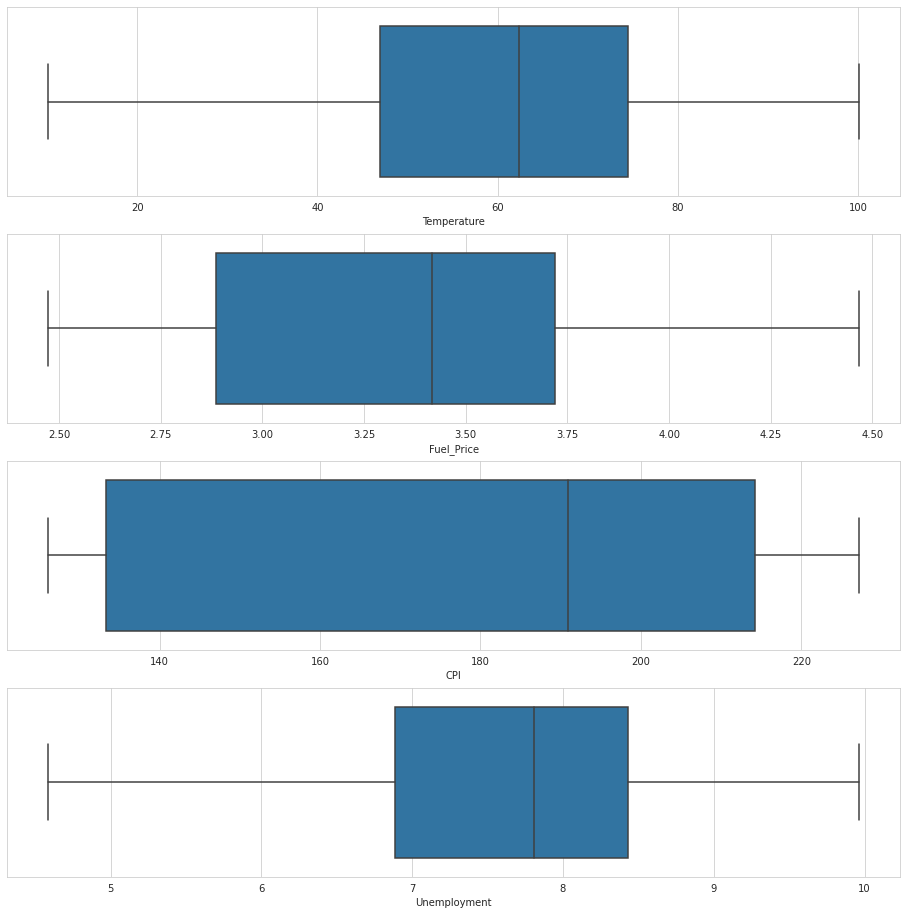

In [53]:
#se validan los datos de los outliers
fig, axis = plt.subplots(4,figsize=(16,16))
X = df_clean[['Temperature','Fuel_Price','CPI','Unemployment']]
for i,column in enumerate(X):
    sns.boxplot(df_clean[column], ax=axis[i])

import warnings
warnings.filterwarnings('ignore')

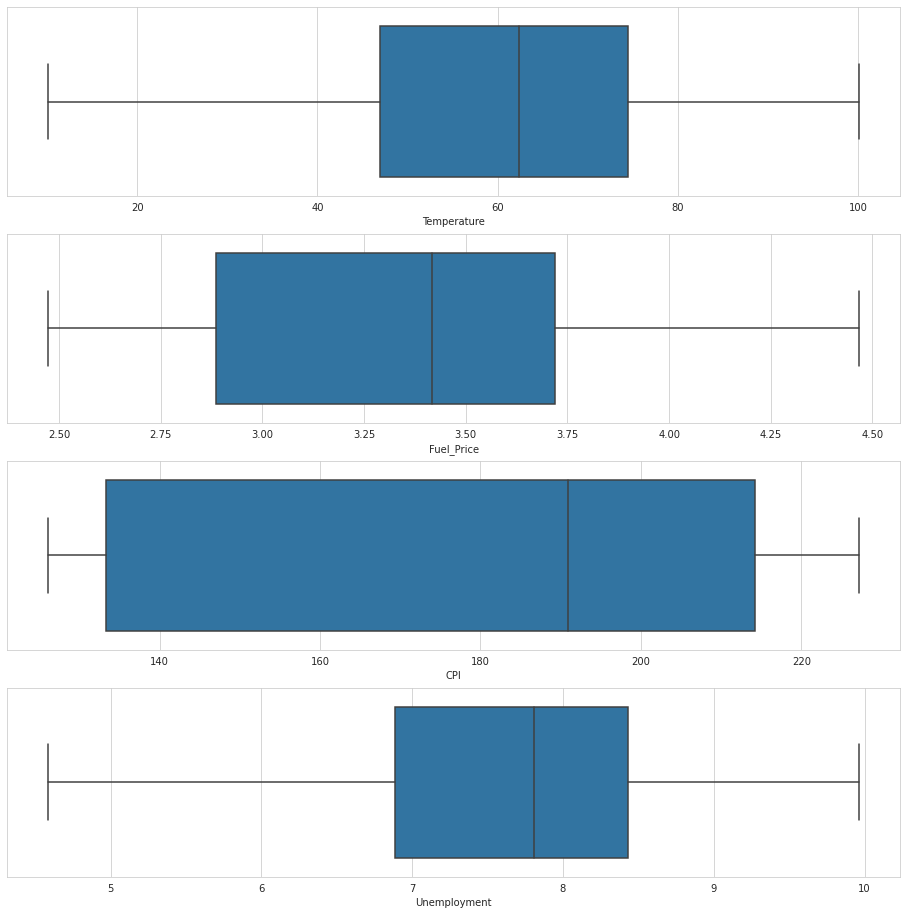

In [54]:
# Verificamos ya no tener valores atipicos
fig, axis = plt.subplots(4,figsize=(16,16))
X = df_clean[['Temperature','Fuel_Price','CPI','Unemployment']]
for i,column in enumerate(X):
    sns.boxplot(df_clean[column],ax=axis[i])


In [55]:
#con este script se pide a Python calcular la correlacion entre variables
df.corr()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day
Store,1.00,-0.34,-0.00,-0.02,0.06,-0.21,0.22,0.00,0.00,0.00,0.00,0.00
Weekly_Sales,-0.34,1.00,0.04,-0.06,0.01,-0.07,-0.11,-0.02,0.06,0.08,0.07,-0.02
Holiday_Flag,-0.00,0.04,1.00,-0.16,-0.08,-0.00,0.01,-0.06,0.08,0.12,0.13,0.04
Temperature,-0.02,-0.06,-0.16,1.00,0.14,0.18,0.10,0.06,0.24,0.24,0.24,0.03
Fuel_Price,0.06,0.01,-0.08,0.14,1.00,-0.17,-0.03,0.78,-0.04,-0.04,-0.03,0.03
CPI,-0.21,-0.07,-0.00,0.18,-0.17,1.00,-0.30,0.07,0.00,0.00,0.01,0.00
Unemployment,0.22,-0.11,0.01,0.10,-0.03,-0.30,1.00,-0.24,-0.02,-0.01,-0.02,-0.00
Year,0.00,-0.02,-0.06,0.06,0.78,0.07,-0.24,1.00,-0.19,-0.19,-0.18,0.01
Quarter,0.00,0.06,0.08,0.24,-0.04,0.00,-0.02,-0.19,1.00,0.97,0.96,0.02
Month,0.00,0.08,0.12,0.24,-0.04,0.00,-0.01,-0.19,0.97,1.00,1.00,0.02


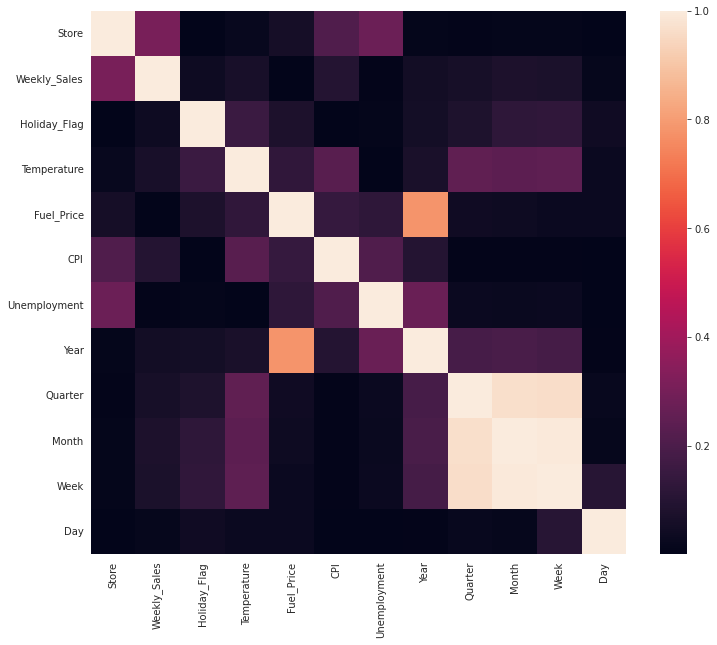

In [56]:
#con este grafico de calor podemos ver las correlaciones de las diferentes columnas, entre mas oscuro mas correlacion existe
plt.figure(figsize = (12,10))
sns.heatmap(df_clean.corr().abs())    

plt.show()

In [57]:
#sns.pairplot(df.drop('Store', axis=1))

# sección 4. **Modelos y Pronostico**

en esta sección del codigo se procede a realizar el modelado de la información

 **ARIMA**

In [58]:
df_arima = df[df["Store"]==15]
df_arima = df_arima[['Date', 'Weekly_Sales']]
df_arima.set_index('Date', inplace =True)
df_arima

,Weekly_Sales
Date,
2010-02-05,"652,122.44"
2010-02-12,"682,447.10"
2010-02-19,"660,838.75"
2010-02-26,"564,883.20"
2010-03-05,"605,325.43"
...,...
2012-09-28,"553,901.97"
2012-10-05,"573,498.64"
2012-10-12,"551,799.63"


In [59]:
df_train = df_arima.iloc[:122]
df_test = df_arima.iloc[-20:]

In [60]:
df_test

,Weekly_Sales
Date,
2012-06-15,"636,737.65"
2012-06-22,"687,085.60"
2012-06-29,"624,099.48"
2012-07-06,"678,024.75"
2012-07-13,"591,335.50"
2012-07-20,"592,369.22"
2012-07-27,"571,190.83"
2012-08-03,"590,739.62"
2012-08-10,"590,453.63"


In [61]:
from statsmodels.tsa.arima.model import ARIMA

In [62]:
Inicio = len(df_train)
Final = len(df_train) + len(df_test) + 30

In [63]:
modelo_arima = ARIMA(df_train, order=(52,0,0))
modelo_arimadef = modelo_arima.fit()

Arima_predict = modelo_arimadef.predict(start=Inicio, end=Final, typ='levels')

In [64]:
Arima_predict

2012-06-08     643,990.88
2012-06-15     641,839.34
2012-06-22     682,303.09
2012-06-29     643,409.76
2012-07-06     630,059.78
2012-07-13     659,555.84
2012-07-20     618,076.91
2012-07-27     598,172.71
2012-08-03     603,135.59
2012-08-10     560,037.89
2012-08-17     630,884.41
2012-08-24     588,047.60
2012-08-31     666,938.27
2012-09-07     637,066.76
2012-09-14     540,908.12
2012-09-21     552,952.84
2012-09-28     492,418.25
2012-10-05     573,257.82
2012-10-12     562,317.97
2012-10-19     588,831.53
2012-10-26     620,378.85
2012-11-02     611,608.52
2012-11-09     595,488.73
2012-11-16     582,782.45
2012-11-23   1,061,436.96
2012-11-30     697,500.48
2012-12-07     757,393.52
2012-12-14     819,461.11
2012-12-21   1,143,260.61
2012-12-28     672,731.72
2013-01-04     542,520.71
2013-01-11     492,785.14
2013-01-18     491,036.51
2013-01-25     423,840.52
2013-02-01     497,756.80
2013-02-08     586,427.70
2013-02-15     615,183.35
2013-02-22     600,035.27
2013-03-01  

In [65]:
df_predict=pd.DataFrame(Arima_predict)

In [66]:
df_predict

,predicted_mean
2012-06-08,"643,990.88"
2012-06-15,"641,839.34"
2012-06-22,"682,303.09"
2012-06-29,"643,409.76"
2012-07-06,"630,059.78"
2012-07-13,"659,555.84"
2012-07-20,"618,076.91"
2012-07-27,"598,172.71"
2012-08-03,"603,135.59"
2012-08-10,"560,037.89"


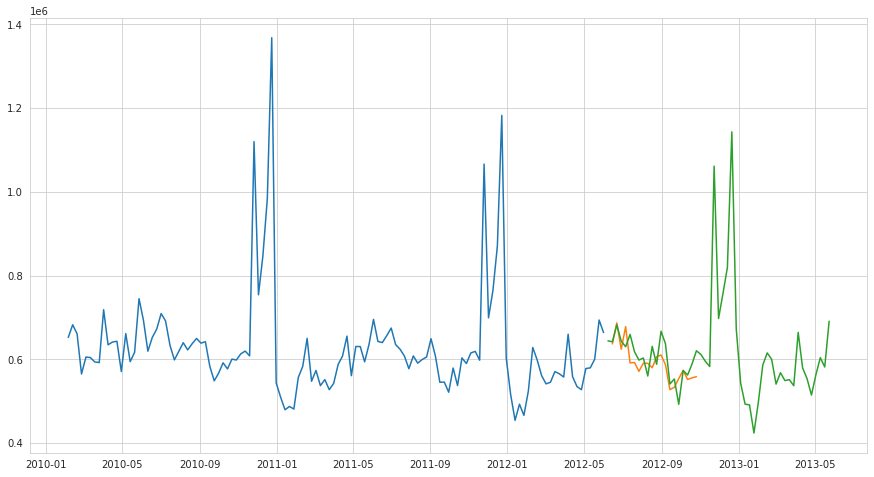

In [67]:
fig, ax = plt.subplots(figsize=(15,8))
plt.plot(df_train)
plt.plot(df_test)
plt.plot(df_predict)

ADF

In [68]:
def performance(a,b):
    print('Mean Absolute Error: ',metrics.mean_absolute_error(a,b))
    print('Mean Square Error: ',metrics.mean_squared_error(a,b))
    print('Root Mean Square Error: ',np.sqrt(metrics.mean_squared_error(a,b)))
    print('Mean Absolute Percentage Error: ', metrics.mean_absolute_percentage_error(a,b))
    
    plt.figure(figsize=(10,8),dpi=60)
    sns.regplot(b,a);
    
def cross_validation(model,a,b):
    cv = cross_val_score(model,a,b,cv=10,scoring='r2')
    print(f'Cross validation: {cv.mean()*100}%')

In [69]:
def adf(series,column_name):
    print(f'Resultados ADF: ,{column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used', 'Observation number'])
    for key, value in dftest[4].items():
        dfoutput['Critical Values (%s)'%key] = value
    print(dfoutput)
    if ((dftest[1] > 0.00) & (dftest[1] <= 0.05)):
        print('Los datos son estacionarios')
    else:
        print('Los datos no son estacionarios')

Prophet

In [70]:
!pip install neuralprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.0/115.0 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.5/706.5 KB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 KB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.0/232.0 KB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 KB 7.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 95.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.1/185.1 KB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [71]:
from neuralprophet import NeuralProphet
from matplotlib import pyplot as plt
import pickle

In [72]:
#path = r'E:\\skillsForIndustry/project_wallmart/data/Walmart_Store_sales.csv'
#wall_data = pd.read_csv(path, header=0, encoding='utf-8')

#wall_data['Date'] = pd.to_datetime(wall_data['Date'],format="%d-%m-%Y",dayfirst=True)
## wall_data.info()
#wall_data['year'] = pd.DatetimeIndex(wall_data['Date']).year
#wall_data['month'] = pd.DatetimeIndex(wall_data['Date']).month
#wall_data['day'] = pd.DatetimeIndex(wall_data['Date']).day
#wall_data.head()

#store_20 = wall_data[wall_data['Store']==20].iloc[:,[1,2,8,9,10]]
## store_20['Date'] = pd.PeriodIndex(store_20.Date,freq='M')
## store_20 = store_20.groupby(['Date'])[['Weekly_Sales','Date']].mean().reset_index()
## store_20 = store_20.rename(columns={'Date':'ds','Weekly_Sales':'y'})
## store_20['ds'] = store_20.ds.astype(str)
## store_20['ds'] = pd.to_datetime(store_20['ds'])
## store_20.info()
#store_20 = store_20.iloc[:,[0,1]]
#store_20 = store_20.rename(columns={'Date':'ds','Weekly_Sales':'y'})
#store_20.info()
#store_20.head()

In [73]:
#plt.plot(store_20['ds'],store_20.y);

In [74]:
#train = store_20[:len(store_20)-15]  # primero datos
#test = store_20[len(store_20)-15:]   # últimos datos
#plt.rcParams["figure.figsize"] = (10,8)
#plt.plot(train.ds,train.y)
#plt.plot(test.ds,test.y)

In [75]:
#m = NeuralProphet()
#m.fit(train, freq='D')

In [76]:
#future = m.make_future_dataframe(train,periods=800)
#np = m.predict(future)
#np.head()

In [77]:
#np.tail()

In [78]:
#plt.rcParams["figure.figsize"] = (10,8)
#m.plot(np);

In [79]:
#m.plot_components(np);

In [80]:
#with open ('forecast_model.pkl','wb') as f:
#    pickle.dump(m,f)

In [81]:
#with open ('forecast_model.pkl','rb') as f:
#    m = pickle.load(f)

In [82]:
#future = m.make_future_dataframe(train,periods=1600)
#np = m.predict(future)
#np.head()

In [83]:
#plt.rcParams['figure.figsize']=(10,8)
#m.plot(np);

**Analisis ANOVA**

In [84]:
from scipy import stats
x=['Holiday_Flag']
y=['Weekly_Sales']
stats.kruskal(x,y)

KruskalResult(statistic=1.0, pvalue=0.31731050786291115)

In [85]:
x=df[df['Holiday_Flag'] == 0]['Weekly_Sales']
y=df[df['Holiday_Flag'] == 1]['Weekly_Sales']
stats.kruskal(x,y)

KruskalResult(statistic=4.963273167380976, pvalue=0.025891154949924652)

In [86]:
df.groupby(['Weekly_Sales'])['Holiday_Flag'].mean()

Weekly_Sales
209,986.25     0.00
213,538.32     0.00
215,359.21     1.00
219,804.85     1.00
220,060.35     0.00
               ... 
3,595,903.20   0.00
3,676,388.98   0.00
3,749,057.69   0.00
3,766,687.43   0.00
3,818,686.45   0.00
Name: Holiday_Flag, Length: 6435, dtype: float64

In [87]:
#se calcula el p_value determinando que los holiday si afectan las ventas, por lo tanto en los Holiday las ventas incrementan
from scipy.stats import f_oneway
f_oneway(x,y)

F_onewayResult(statistic=8.766880898711571, pvalue=0.0030786992638024567)

**Linear Regression**

In [88]:
#con este script se calcula la regresion lineal or linear Regression :
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
X = df_clean[['Store','Fuel_Price','CPI','Unemployment','Day','Month','Year']]
Y = df_clean['Weekly_Sales']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)

Linear Regression:

Accuracy: 13.390979219171484
Mean Absolute Error: 436539.3243393998
Mean Squared Error: 277137850883.60205
Root Mean Squared Error: 526438.8386922093


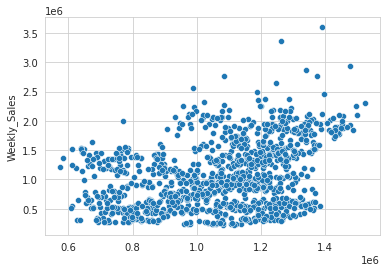

In [89]:
print('Linear Regression:')
print()
reg = LinearRegression()
reg.fit(X_train, Y_train)
Y_pred = reg.predict(X_test)
print('Accuracy:',reg.score(X_train, Y_train)*100)
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
sns.scatterplot(Y_pred, Y_test)

import warnings
warnings.filterwarnings('ignore')

Random Forest Regressor:

Accuracy: 96.01884741077359
Mean Absolute Error: 59115.22369893997
Mean Squared Error: 12397238183.442127
Root Mean Squared Error: 111342.88564359254


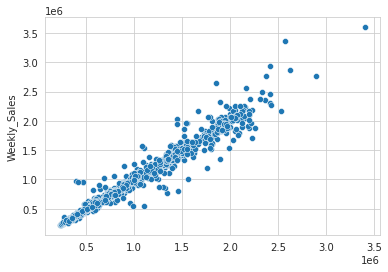

In [90]:
#se calcula el random forest regressor
from sklearn.ensemble import RandomForestRegressor
print('Random Forest Regressor:')
print()
rfr = RandomForestRegressor()        
rfr.fit(X_train,Y_train)
Y_pred = rfr.predict(X_test)
print('Accuracy:',rfr.score(X_test, Y_test)*100)
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
sns.scatterplot(Y_pred, Y_test)


import warnings
warnings.filterwarnings('ignore')

In [91]:
#con este script se solicita a Python calcular el analsis de variaza entre 'Holiday_ Flag' vs 'Weekly_Sales', el modelo indica que la variacion
#afecta las ventas de manera significativa

model = smf.ols ('Holiday_Flag ~ Weekly_Sales', data = df).fit()
aov_table = anova_lm(model, type=2)
anova_result = sm.stats.anova_lm(model, type=2)
print(aov_table)

                   df  sum_sq  mean_sq    F  PR(>F)
Weekly_Sales     1.00    0.57     0.57 8.77    0.00
Residual     6,433.00  417.96     0.06  NaN     NaN


In [92]:
import prophet as ppt

In [93]:
import scipy.stats as stats
from pmdarima import auto_arima

In [94]:
#df = train.loc[(train.Store == 1),['Date','Weekly_Sales']]
#print('Earliest date: %s; Latest date: %s' % (df['Date'].min(), df['Date'].max()))

In [95]:
df.set_index('Date', inplace=True)

In [96]:
df.groupby('Date')

<AxesSubplot:title={'center':'Walmart Sales in One Department of One Store Feb 2010 to Oct 2012'}, xlabel='Date'>

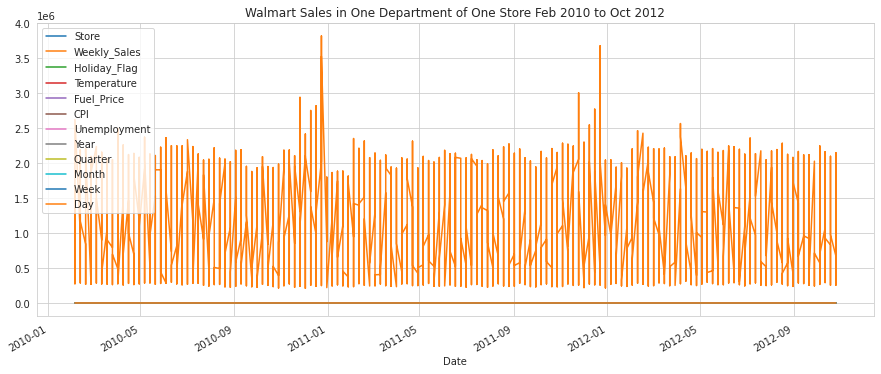

In [97]:
df.plot(figsize=(15, 6),title="Walmart Sales in One Department of One Store Feb 2010 to Oct 2012")

In [98]:
df.index = pd.to_datetime(df.index)

ValueError: ignored

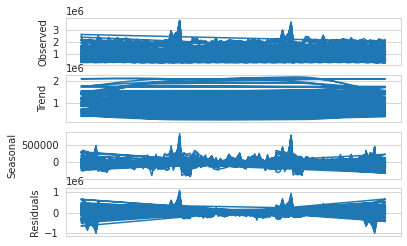

In [99]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

advanced_decomposition = STL(df.Weekly_Sales, period=52).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 12, 12), [2010, 2011, 2012])

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
#from pmdarima import auto_arima
#stepwise_model = auto_arima(df, start_p=1, d=1, start_q=1,
#                           max_p=3, max_q=3, m=12,
#                           start_P=0, seasonal=True,
#                           D=1, trace=True,
#                           error_action='ignore',  
#                           suppress_warnings=True)
#print(stepwise_model.aic())

In [ ]:
#train = df.loc[:'2012-05-01']
#test = df.loc['2012-05-01':]
#stepwise_model.fit(train)

In [ ]:
#from statsmodels.tsa.arima_model import ARMA

In [ ]:
#import warnings
#warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
#                        FutureWarning)
#warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
#                        FutureWarning)

#warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)

In [ ]:
#ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 0),
#   out_of_sample_size=0, scoring='mse', scoring_args={},
#   seasonal_order=(0, 1, 1, 12), solver='lbfgs', start_params=None,
#   suppress_warnings=True, transparams=True, trend='c')

In [ ]:
#future_forecast = stepwise_model.predict(n_periods=len(test))

In [ ]:
#future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
#pd.concat([test,future_forecast],axis=1).plot()

In [ ]:
#d.concat([df,future_forecast],axis=1).plot(figsize=(15, 6),
#                                             title="Walmart Sales in One Department of One Store Feb 2010 to Oct 2012")

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# import datetime as dt
from datetime import datetime # Trabajar con fechas

# Metricas de desempeño de modelos 
import scipy.stats as stats
import statistics
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler  # Estandarización de los datos
from sklearn.model_selection import cross_val_score

# Series de tiempo
# from statsmodels.tsa.seasonal import seasonal_decompose # graficas de estacionalidad y tendencia
# from statsmodels.tsa.stattools import adfuller # prueba 
# from statsmodels.tsa.statespace.sarimax import SARIMAX #SARIMAX
# import pmdarima as pm # autoarima
# import statsmodels.formula.api as smf

# Prophet

# !pip3 install more-itertools --user
# !pip install prophet --user
import itertools
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly

# Formato de visualización por centenas
pd.options.display.float_format = '{:,.2f}'.format

# Graficas
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns;sns.set_theme(color_codes=True)

# Tamaño del cuadro de las gráficas por defult
plt.rcParams["figure.figsize"] = (12,6)

import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("Setup complete")

In [ ]:
#path = r'E:\\skillsForIndustry/project_wallmart/data/Walmart_Store_sales.csv'
#wall_data = pd.read_csv(path, header=0, encoding='utf-8')

In [ ]:
#wall_data['Date'] = pd.to_datetime(wall_data['Date'],format="%d-%m-%Y",dayfirst=True)
#wall_data.info()
#wall_data.head()

Frecuencia de Tiempo

In [ ]:
## Mensual con frecuencia
## stores = wall_data
## stores = stores.iloc[:,[1,0,2]]
## stores.Date = pd.PeriodIndex(stores.Date, freq='M')
## # stores = stores.groupby(['Date'])['Weekly_Sales'].aggregate([sum,min,'mean','count']).reset_index()
## stores = stores.groupby(['Date','Store'])['Weekly_Sales'].mean().reset_index()
## stores['Date'] = stores['Date'].astype(str)
## stores['Store'] = stores.Store.astype(str)
## stores['Date'] =pd.to_datetime(stores['Date'])
## stores.head()

## Mensual sin frecuencia 
## stores = wall_data
## stores = stores.iloc[:,[1,0,2]]
## stores['year'] = pd.DatetimeIndex(stores['Date']).year
## stores['month'] = pd.DatetimeIndex(stores['Date']).month
## stores= stores.groupby(['year','month','Store'])[['Weekly_Sales']].mean().reset_index()
## stores['year_str']=stores.year.apply(str)
## stores['month_str']=stores.month.apply(str)
## stores['Store'] = stores.Store.astype(str)
## stores['year_month'] = stores[['year_str','month_str']].apply('-'.join,axis=1)
## stores['Date']=pd.to_datetime(stores['year_month'],format="%Y-%m",yearfirst=True)
## stores = stores.iloc[:,[7,2,3]]
## stores.head()


## Semanal
#stores = wall_data
#stores = stores.iloc[:,[1,0,2]]
## stores
## stores.Date = pd.PeriodIndex(stores.Date, freq='w')
## stores = stores.groupby(['Date','Store'])['Weekly_Sales'].sum().reset_index()
## stores['Date'] = stores['Date'].astype(str)
#stores['Store'] = stores.Store.astype(str)
## stores[['sb','be']] = stores['Date'].str.split(pat='/',expand=True)
## stores = stores.iloc[:,[3,1,2]]
## stores.columns = ['Date','Store','Weekly_Sales']
#stores['Date'] =  stores['Date'] =pd.to_datetime(stores['Date'])
#stores.info()

In [ ]:
num_store = stores['Store'].unique()
num_store

In [ ]:
## for i in num_store:
##     df = stores[stores['store']==i]
##     print(frame)
#mes = {}
#for store in num_store:
#    df = stores[stores['Store']==store].copy()
#    df.drop('Store',axis=1, inplace=True)
#    mes[store] = df
#    df.columns = ['ds','y']
   
## Elegir una tienda    
## mes['20']

In [ ]:
## mes['20']

Performance

In [ ]:
#def performance(a,b):
#    print('Mean Absolute Error: ',metrics.mean_absolute_error(a,b))
#    print('Mean Square Error: ',metrics.mean_squared_error(a,b))
#    print('Root Mean Square Error: ',np.sqrt(metrics.mean_squared_error(a,b)))
#    print('Mean Absolute Percentage Error: ', metrics.mean_absolute_percentage_error(a,b))
    
#    plt.figure(figsize=(10,8),dpi=60)
#    sns.regplot(b,a);

Diferencias

In [ ]:
## def dif(st):
##     prev_values = st.ds.shift()
##     dif = st.ds - prev_values
##     dif.plot()

Estacionalidad

In [ ]:
## def estacionalidad(st):
##     est = seasonal_decompose(st.iloc[1:],model='additive',period = 12)
##     est.plot();

Test

In [ ]:
#def tra_tes(st):
#    train = st.sort_values('ds')[:len(st)-12]  # primero datos
#    test = st.sort_values('ds')[len(st)-12:]   # últimos datos 
#    return train,test

Mensual

In [ ]:
#m_20 =  mes['20'].rename_axis(index=None,columns=None)
#m_14 =  mes['14'].rename_axis(index=None,columns=None) # No son datos estacionarios
#m_5 =  mes['5'].rename_axis(index=None,columns=None)

Prophet

In [ ]:
#m_20.head()

In [ ]:
#m = Prophet(interval_width= 0.95)
#m.fit(m_20)
## training_run = m.fit(m_20)

In [ ]:
## Mensual
#future = m.make_future_dataframe(periods=80, freq='W-FRI')

## Diario
## future = m.make_future_dataframe(periods=390, freq='D')

In [ ]:
#future.tail()

In [ ]:
#forecast = m.predict(future)

In [ ]:
#forecast.tail()

In [ ]:
#plot = m.plot(forecast)

In [ ]:
#plot2 = m.plot_components(forecast)

Entrenamiento

In [ ]:
#train, test = tra_tes(m_20)
## train, test = tra_tes(m_14)
## train, test = tra_tes(m_5)

In [ ]:
#sns.lineplot(data=test, x = 'ds',y ='y', label='test');
#sns.lineplot(data=train, x = 'ds',y ='y', label='train');

In [ ]:
#m = Prophet(interval_width=0.95, changepoint_prior_scale=0.0001, yearly_seasonality=20)

## Pasandole toda la data
## m.fit(m_20)
## m.fit(m_14)
## m.fit(m_5)

## Pasandole test o train
#m.fit(train)
## m.fit(test)

In [ ]:
## Construir futuro
#future = m.make_future_dataframe(periods=12, freq='W-FRI')

## Hacer predicciones
#pp = m.predict(future)
#pp.tail()

In [ ]:
## plot = m.plot(pp)

In [ ]:
## plot2 = m.plot_components(pp)

In [ ]:
#pp = pd.DataFrame({'Date':pp[-12:]['ds'],'Pred':pp[-12:]['yhat']})
## pp.set_index('Date', inplace= True)
## pp.index.freq = 'MS'
#pp

In [ ]:
#train.columns = ['Date','Pred']
#test.columns = ['Date','Pred']

#x_train = train.Date
#y_train  = train.Pred
#x_test = test.Date
#y_test  = test.Pred
#x_pp = pp.Date
#y_pp = pp.Pred

In [ ]:
#fig = make_subplots(specs=[[{"secondary_y": True}]])

#fig.add_trace(
#    go.Scatter(x = x_test,y = y_test, name="test"),
#    secondary_y=False
#)

#fig.add_trace(
#    go.Scatter(x = x_pp ,y = y_pp, name="prophet"),
#    secondary_y=True
#)

#fig.update_layout(
#    title_text="Prophet Values",
#    width = 1000, height = 600
#)

#fig.show()

In [ ]:
#fig = make_subplots(specs=[[{"secondary_y": True}]])

#fig.add_trace(
#    go.Scatter(x = x_test,y = y_test, name="test"),
#    secondary_y=False
#)

#fig.add_trace(
#    go.Scatter(x = x_train,y = y_train, name="train"),
#    secondary_y=False
#)

#fig.add_trace(
#    go.Scatter(x = x_pp ,y = y_pp, name="prophet"),
#    secondary_y=True
#)

#fig.update_layout(
#    title_text="Prophet Values",
#    width = 1000, height = 600
#)

#fig.show()

In [ ]:
#print('Accuracy test(R2): ', metrics.r2_score(test.Pred,pp.Pred)*100)
#performance(test.Pred,pp.Pred)

In [ ]:
#train, test = tra_tes(m_20)

Almacenar los datos

In [ ]:
#forecast = pd.DataFrame({'ds':pd.to_datetime([x for x in range(2013,2017)],
#                                            format='%Y'), 'y':np.nan})
#forecast.tail()

Forecast train

In [ ]:
## forecast_train = m.predict(train)
## forecast_final = pd.concat([forecast_train,forecast])

#forecast_test = m.predict(test)
#forecast_final = pd.concat([forecast_test,forecast])

In [ ]:
## m.plot_components(forecast_train);
## m.plot_components(forecast_test);


## --------------------------------------------------
#m.plot_components(forecast_test);

In [ ]:
#m.plot(forecast_final[forecast_final['ds'].dt.month==9])
#plt.show();

In [ ]:
## Construir futuro
#future = m.make_future_dataframe(periods=12, freq='MS')

## Hacer predicciones
#pp = m.predict(future)
#pp.tail()

In [ ]:
#pp = pd.DataFrame({'Date':pp[-12:]['ds'],'Pred':pp[-12:]['yhat']})
## pp.set_index('Date', inplace= True)
## pp.index.freq = 'MS'
#pp